# Movie Review Sentiment Analysis (NLP)

Import necessary libraries

In [1]:
# data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

# nlp packages
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords

# sklearn for modeling
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize

# sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score


In [2]:
df = pd.read_csv("./data/IMDB-Dataset.csv")

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We have a balanced dataset therefore we do not need to use oversampling or undersampling techniques.

In [5]:
df.review.isnull().sum()

0

In [6]:
len(df)

50000

No missing values in review and sentiment label.

### Binarizing sentiment column to 0 and 1 for binary output.

In [7]:
#binarizing emotion column
emotion_dict = {'negative': 0, 'positive': 1}
df['sentiment'] = df['sentiment'].map(emotion_dict)

In [8]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

### Exploratory Data Analysis

In [9]:
Review_Positives = df [ (df['sentiment'] == 1) ]
Review_Positives

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
...,...,...
49983,"I loved it, having been a fan of the original ...",1
49985,Imaginary Heroes is clearly the best film of t...,1
49989,I got this one a few weeks ago and love it! It...,1
49992,John Garfield plays a Marine who is blinded by...,1


1. lower-cased

In [10]:
Review_Positives['review'].str.lower()

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
4        petter mattei's "love in the time of money" is...
5        probably my all-time favorite movie, a story o...
                               ...                        
49983    i loved it, having been a fan of the original ...
49985    imaginary heroes is clearly the best film of t...
49989    i got this one a few weeks ago and love it! it...
49992    john garfield plays a marine who is blinded by...
49995    i thought this movie did a down right good job...
Name: review, Length: 25000, dtype: object

2. tokenize

In [11]:
corpus_review_pos = Review_Positives['review'].to_list()

In [12]:
def tokenize_reviews(corpus):
    tokens = []
    for review in corpus:
        tokens.extend(word_tokenize(review))
    return tokens

In [13]:
tokens_reviews_pos = tokenize_reviews(corpus_review_pos)

In [14]:
freq = FreqDist(tokens_reviews_pos)
freq.most_common(30)

[('the', 294322),
 (',', 282003),
 ('.', 232518),
 ('and', 169578),
 ('a', 156882),
 ('of', 149854),
 ('to', 129272),
 ('is', 113244),
 ('/', 98198),
 ('>', 98073),
 ('<', 97994),
 ('br', 97952),
 ('in', 92064),
 ('I', 75789),
 ('it', 74899),
 ('that', 67002),
 ("'s", 63028),
 ('this', 54116),
 ('as', 47499),
 ('was', 44595),
 ('with', 44281),
 ('The', 43397),
 ('for', 41914),
 ('film', 40162),
 (')', 36776),
 ('(', 36182),
 ('movie', 36180),
 ('but', 33529),
 ("''", 32179),
 ('on', 32054)]

Stopwords and punctuations are the most frequent words

### Remove Stopwords and punctuations

In [15]:
stop_lst = stopwords.words('english')
stop_lst += list(string.punctuation)
# write a function to remove stopwords and punctuations

def remove_stopwords(tokens, stop_list = stop_lst):
    
    
    #encoding/decoding tokens to eliminate unrecognized symbols and 
    #eliminating external links
    
    tokens_stopped = [word.encode('ascii','ignore').decode() 
                      for word in tokens 
                      if (word not in stop_list) & 
                      (word.startswith('http') == False)]
    

    return tokens_stopped

In [16]:
stop_lst += ['br',"'s",'film','films','movies', 'movie',"''", '``', "n't", "...", ]

In [17]:
tokens_reviews_pos_nostopwords = remove_stopwords(tokens_reviews_pos, stop_lst)

In [18]:
freq = FreqDist(tokens_reviews_pos_nostopwords)
freq.most_common(30)

[('I', 75789),
 ('The', 43414),
 ('one', 23978),
 ('It', 18608),
 ('like', 16426),
 ('This', 14960),
 ('good', 13826),
 ('story', 12112),
 ('great', 11825),
 ('time', 11623),
 ('see', 11514),
 ('would', 11099),
 ('really', 10446),
 ('well', 10036),
 ('also', 9379),
 ('much', 8777),
 ('even', 8333),
 ('first', 8297),
 ('people', 8178),
 ('get', 8029),
 ('love', 7771),
 ('best', 7587),
 ('way', 7467),
 ('many', 7089),
 ('life', 7078),
 ('could', 7064),
 ('think', 7035),
 ('made', 6923),
 ('But', 6914),
 ('characters', 6880)]

Use wordcloud to visualize frequency of words

In [19]:
from wordcloud import WordCloud

In [20]:
# Write a function for wordcloud generation
def generate_wordcloud(tokens, collocations=False, background_color='white', 
                       colormap='Blues', display=True):
    
    """Function generates and returns a wordcloud based on a tokens list passed in.
    -------------------------------
    Arguments:
    tokens: a tokens list
    collocations: Whether to include collocations (bigrams) of two words
    background_color: background color of the resulting word cloud
    colormap: the color map for the words that will be in the word cloud
    display: Whether to show the resulting wordcloud"""
    
    ## Initalize a WordCloud
    wordcloud = WordCloud(collocations=collocations,
                          background_color=background_color, 
                          colormap=colormap, 
                          width=500, height=300)

    ## Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    ## Plot with matplotlib
    if display:
        plt.figure(figsize = (12, 15), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis('off');
    return wordcloud

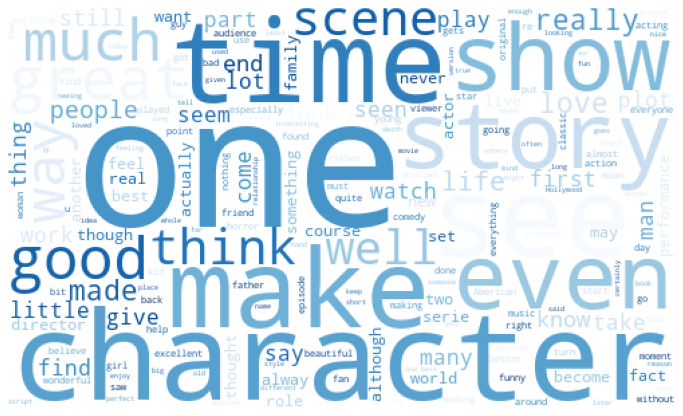

In [21]:
wordcloud_reviews_pos = generate_wordcloud(tokens_reviews_pos_nostopwords, collocations = True)

The positive movie reviews tend to bring up words such as "character", reviwers might think character plays a main role to have good review for a movie.

### Looking at negative reviews

In [22]:
Review_Negatives = df [ (df['sentiment'] == 0) ]
Review_Negatives['review'].str.lower()
corpus_review_neg = Review_Negatives['review'].to_list()
tokens_reviews_neg = tokenize_reviews(corpus_review_neg)


[('the', 279075),
 (',', 262028),
 ('.', 235464),
 ('a', 152221),
 ('and', 139540),
 ('of', 135233),
 ('to', 134386),
 ('/', 104257),
 ('>', 104177),
 ('<', 104100),
 ('br', 103996),
 ('is', 101496),
 ('I', 87505),
 ('in', 81075),
 ('it', 77032),
 ('that', 70742),
 ('this', 66326),
 ("'s", 58740),
 ('was', 54495),
 ('movie', 47633),
 ('The', 44420),
 ('for', 40680),
 ('with', 40462),
 ("n't", 39445),
 ('as', 37501),
 ('film', 35778),
 ('but', 35335),
 (')', 34492),
 ('``', 34316),
 ("''", 34248)]

In [31]:
stop_lst += ['I',"The",'film','like','movies', 'It', 'would','This','And','But','There','think', 'one','even' ]

In [32]:
tokens_reviews_neg_nostopwords = remove_stopwords(tokens_reviews_neg, stop_lst)
freq = FreqDist(tokens_reviews_neg_nostopwords)
freq.most_common(30)

[('good', 13756),
 ('bad', 13412),
 ('really', 11821),
 ('time', 11324),
 ('could', 11134),
 ('see', 10351),
 ('get', 9794),
 ('much', 9678),
 ('story', 9510),
 ('people', 8907),
 ('make', 8899),
 ('made', 8346),
 ('plot', 7696),
 ('acting', 7659),
 ('way', 7277),
 ('characters', 7093),
 ('first', 7060),
 ('character', 6775),
 ('watch', 6579),
 ('know', 6533),
 ('seen', 6446),
 ('better', 6420),
 ('never', 6221),
 ('If', 6116),
 ('ever', 6104),
 ('well', 5893),
 ('also', 5856),
 ('say', 5816),
 ('two', 5672),
 ('A', 5607)]

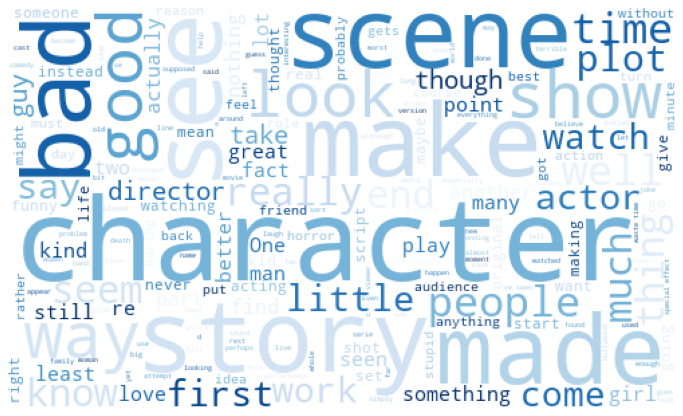

In [33]:
wordcloud_reviews_neg = generate_wordcloud(tokens_reviews_neg_nostopwords, collocations = True)

Negative reviews seem to focus on the "story", "plot", "acting", "character".